# Introduction
The goal of the project is to train a Convolution Neural Network to detect metastatic cancer in small image patches taken from larger digital pathology scans. We will be using data from Kaggle (https://www.kaggle.com/c/histopathologic-cancer-detection/overview) which is a modified version of a benchmark dataset called PatchCamelyon (PCam). 

This is a binary classification problem. We have labels for each image and we want to the model to be able to detect at least one pixel of tumor tissue which is at the center of a 32x32 pixel region for the tissue image. A positive label (has tumor) is indicated by the above; one pixel of tumor tissue which is at the center of the 32x32 pixel square within the 96x96 pixel image. 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
from glob import glob 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


2024-04-15 13:21:14.094999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 13:21:14.095128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 13:21:14.267986: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# EDA

In [2]:
# Load the paths.
print(os.listdir("../input/histopathologic-cancer-detection"))
train = "../input/histopathologic-cancer-detection/train/"
test = "../input/histopathologic-cancer-detection/test/"

# Load the labels.
labels = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
print(labels.head())

# Get counts of data.
print("Training size : ", len((os.listdir(train))))
print("Testing size : ", len((os.listdir(test))))


['sample_submission.csv', 'train_labels.csv', 'test', 'train']
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Training size :  220025
Testing size :  57458


The training dataset contains 220,025 images and the testing dataset contains 57,458 images. 

label
0    130908
1     89117
Name: count, dtype: int64


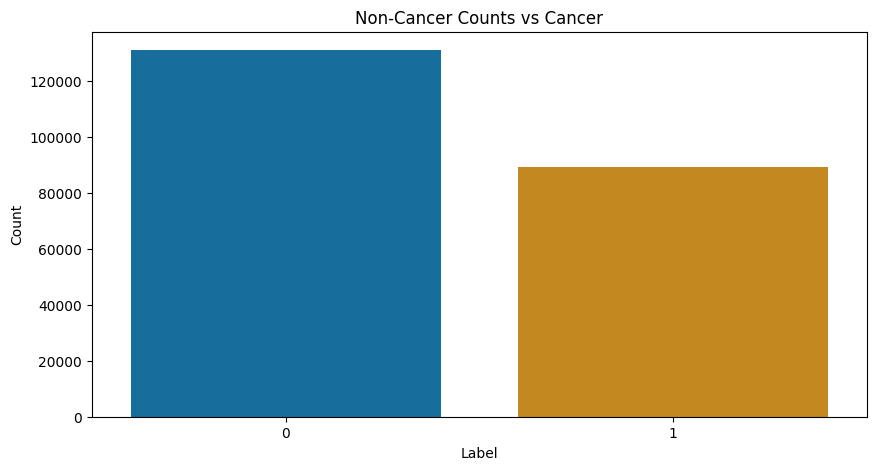

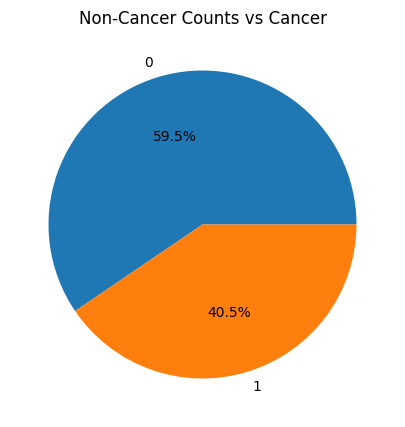

In [3]:
# Get counts of cancer vs non-cancer in training data. 
labels_count = labels.label.value_counts()
print(labels_count)

# Create bar plot.
plt.figure(figsize=(10,5))
sns.countplot(x=labels['label'], palette='colorblind')
plt.title('Non-Cancer Counts vs Cancer')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()


# Create pie chart.
plt.figure(figsize=(10,5))
plt.pie(labels_count, labels=labels_count.index, autopct='%1.1f%%')
plt.title('Non-Cancer Counts vs Cancer')
plt.show()

A 0 label is considered a non-cancerous image and a 1 label is considered a cancerous image. There are 130,908 images which are not labeled as cancerous tissue and 89,117 images labeled as cancerous tissue. 
About 60% of the data does not have a cancerous pixel in the middle 32x32 pixels of the images and about 40% of the data has a cancerous pixel in the middle 32x32 pixels of the images. 

In [4]:
# Look at dtypes. 
print(labels.dtypes)

id       object
label     int64
dtype: object


The dtypes seem to make sense. 

label:  0


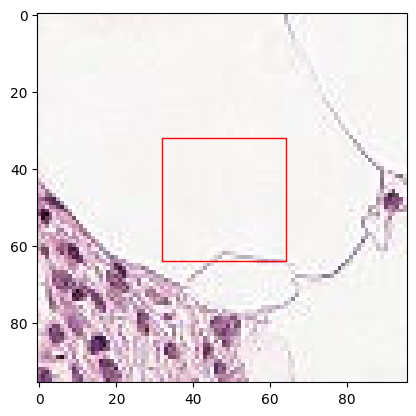

label:  1


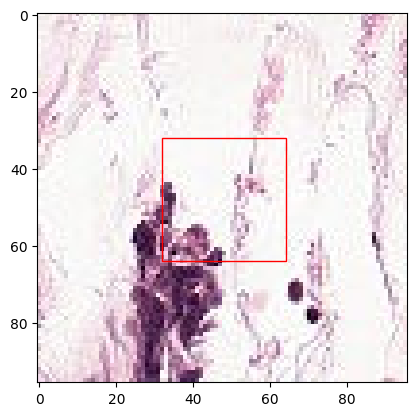

label:  0


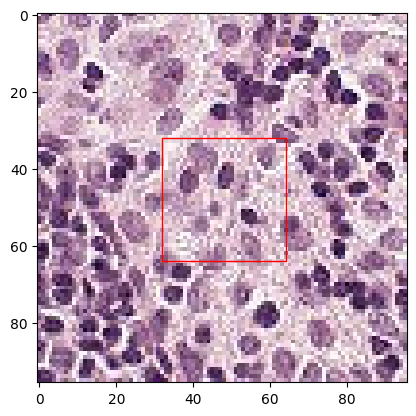

label:  0


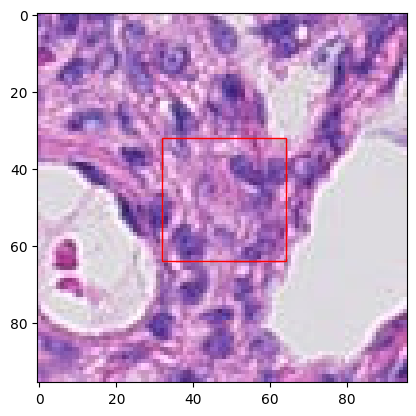

label:  0


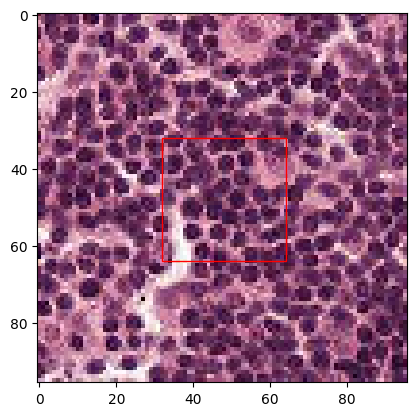

In [5]:
# Viewing some images. 
for i in range(5):
    tif = train + labels.iloc[i]['id'] + '.tif' # tif path
    img = plt.imread(tif)
    print("label: ",labels.iloc[i]['label'])
    
    # Create figure and axes.
    fig, ax = plt.subplots(1)
    
    # Display the image.
    ax.imshow(img)

    # Create a Rectangle patch and add it.
    rect = patches.Rectangle((32,32),32,32,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

    plt.show()

Though it is hard to tell, the cancerous image in the 2nd image above, tends to be less uniform in the shape of cells. 

# Model Architecture

I will be using a Convolution Neural Network (CNN) to predict if the image has cancerous cells or not. 

The first model will be a basic model with a convolutional layer followed by maxpooling and there will be 2 of these layers. Flattening and then the sigmoid function will be applied. 


The second model will have the convolution layer followed by batch normalization, maxpooling, and then a drop out. There will be 3 of these layers. Flattening, a dense layer, a normalization layer, a dropout layer, and the sigmoid function. 

Info on the models:

**Normalization** - scale image (1/255).

**Dropout** - Dropout layers will set weights to 0 which results in less weights being used for training.

**Optimization** - Adaptive Moment Estimation (Adam) optimizer is a stochastic gradient descent that scales the learning rate. 

**Overtraining** - To try and prevent overtraining I will incorporate early stopping and reduced learning. Early stopping will keep track of the validation loss and stop early if it starts to rise. Reduced learning will reduce the learning rate when the model stops improving. 


In [6]:
# Splitting the data. 
y = labels['label']
df_train, df_val = train_test_split(labels, test_size=0.10, random_state=1234, stratify=y)
print("Training dataset size: ", len(df_train))
print("Testing dataset size: ", len(df_val))

# Make a path column for both dataframes.
df_train['path'] = train + df_train['id'] + '.tif'
df_val['path'] = train + df_val['id'] + '.tif'
df_train.head()

# Convert labels to string.
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

Training dataset size:  198022
Testing dataset size:  22003


In [7]:
# Create data generators.
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col="path",
    y_col="label",
    target_size=(96, 96), 
    batch_size=256,
    class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col="path",
    y_col="label",
    target_size=(96, 96),
    batch_size=256,
    class_mode='binary')

Found 198022 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


In [8]:
# Setup GPU accelerator.
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [9]:
# Use gpu to create the first model. 
with strategy.scope():
    # Define the model.
    model_1 = Sequential()
    model_1.add(Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model_1.add(MaxPooling2D(pool_size=(2, 2)))

    model_1.add(Conv2D(32, (3, 3), activation='relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2)))

    model_1.add(Flatten())
    model_1.add(Dense(1, activation='sigmoid'))

    # Compile the model.
    model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model_1)
    
model_1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


<Sequential name=sequential, built=True>


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        15,489 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,577 (80.38 KB)

 Trainable params: 20,577 (80.38 KB)

 Non-trainable params: 0 (0.00 B)

# Model 1 fit and AUC

In [10]:
# Define early stopping.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_learning = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1)


# Train the model.
model_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10, 
    callbacks=[reduce_learning, early_stopping])


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-15 13:30:24.676016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.25641, expected 6.41243
2024-04-15 13:30:24.676068: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.67779, expected 5.83381
2024-04-15 13:30:24.676079: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 7.0276, expected 6.18361
2024-04-15 13:30:24.676089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.70083, expected 5.85685
2024-04-15 13:30:24.676098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:113

  1/773 ━━━━━━━━━━━━━━━━━━━━ 4:50:49 23s/step - accuracy: 0.4219 - loss: 0.7537

I0000 00:00:1713187828.478424      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


703/773 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.7307 - loss: 0.5450

2024-04-15 13:55:23.382453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8838: 6.57554, expected 5.75885
2024-04-15 13:55:23.382514: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8839: 6.92544, expected 6.10874
2024-04-15 13:55:23.382524: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8840: 7.05503, expected 6.23834
2024-04-15 13:55:23.382532: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8841: 6.88113, expected 6.06444
2024-04-15 13:55:23.382540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8847: 6.86839, expected 6.05169
2024-04-15 13:55:23.382547: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8850: 6.81941, expected 6.00272
2024-04-15 13:55:23.382555: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8851: 6.9941, expected 6.17741
2024-04-15 13:55:23.382563: E exter

773/773 ━━━━━━━━━━━━━━━━━━━━ 1831s 2s/step - accuracy: 0.7337 - loss: 0.5415 - val_accuracy: 0.7956 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 2/10
  1/773 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8125 - loss: 0.4349

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-15 14:00:39.193338: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1981: 3.93724, expected 3.43973
2024-04-15 14:00:39.193408: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3522: 3.85243, expected 3.35492
2024-04-15 14:00:39.193431: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6613: 3.69897, expected 3.20146
2024-04-15 14:00:39.193442: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7328: 3.85511, expected 3.3576
2024-04-15 14:00:39.193525: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26511: 7.1162, expecte

773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8125 - loss: 0.4349 - val_accuracy: 0.7819 - val_loss: 0.4402 - learning_rate: 0.0010
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 547s 701ms/step - accuracy: 0.7861 - loss: 0.4675 - val_accuracy: 0.7913 - val_loss: 0.4655 - learning_rate: 0.0010
Epoch 4/10
  1/773 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.7891 - loss: 0.4652
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.7891 - loss: 0.4652 - val_accuracy: 0.7860 - val_loss: 0.4589 - learning_rate: 0.0010
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 533s 686ms/step - accuracy: 0.8094 - loss: 0.4256 - val_accuracy: 0.8104 - val_loss: 0.4258 - learning_rate: 1.0000e-04
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.8203 - loss: 0.4167 - val_accuracy: 0.7819 - val_loss: 0.4901 - learning_rate: 1.0000e-04
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8122 - lo

In [11]:
# Create test generator 1.
tf.random.set_seed(1234)
test_generator = train_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col="path",
    y_col="label",
    target_size=(96, 96),
    batch_size=1,
    class_mode='binary', 
    shuffle=False)

# Make predictions for validation data. 
y_pred_keras = model_1.predict(test_generator, steps=len(df_val))
false_pos_r, true_pos_r, thresholds_keras = roc_curve(test_generator.classes, y_pred_keras)
auc_val = auc(false_pos_r, true_pos_r)
auc_val

Found 22003 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-15 14:27:47.622035: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8845: 5.19126, expected 4.55948
2024-04-15 14:27:47.622089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8846: 5.23895, expected 4.60718
2024-04-15 14:27:47.622107: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8882: 4.9463, expected 4.31452
2024-04-15 14:27:47.622120: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8896: 5.24628, expected 4.6145
2024-04-15 14:27:47.622130: E external/local_xla/xla/service/gpu/buffer_compar

22003/22003 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step


0.6486743096967822

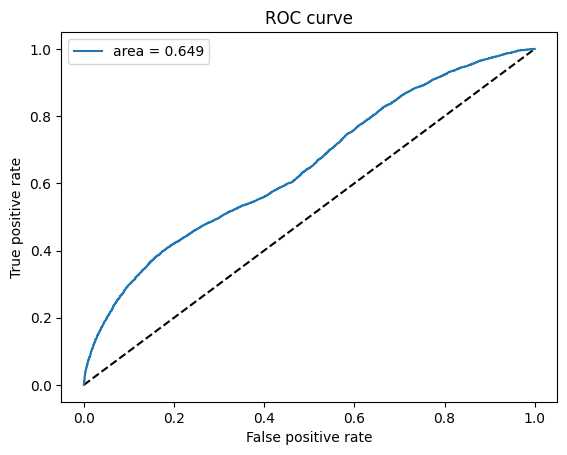

In [12]:
# Plot auc. 
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_pos_r, true_pos_r, label='area = {:.3f}'.format(auc_val))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [13]:
# # Load the test data. 
# test = pd.read_csv("../input/histopathologic-cancer-detection/sample_submission.csv")
# print(test)

# # Test directory. 
# test_dir = "../input/histopathologic-cancer-detection/test/"

# # Add a path column to the test dataframe.
# test['path'] = test_dir + test['id'] + '.tif'

# # Create a data generator for the test data.
# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_dataframe(
#     dataframe=test,
#     x_col="path",
#     y_col=None,  
#     target_size=(96, 96),
#     batch_size=256,
#     class_mode=None,  
#     shuffle=False)  

# # Use the model to make predictions.
# predictions = model_1.predict(test_generator)

In [14]:
# # Convert predictions to class labels.
# test['label'] = (predictions > 0.5).astype(int)

# # Remove path column.
# test.drop(['path'], axis=1, inplace=True)

# # Write submission. 
# test.to_csv("submission.csv", index = False, header = True)
# print(pd.read_csv("submission.csv"))

public score = 0.7903 or 79.03%

# Model 2 fit and AUC

In [15]:
with strategy.scope():
    # Define the model.
    model_2 = Sequential()
    model_2.add(Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling2D(pool_size=(2, 2)))
    model_2.add(Dropout(0.25))

    model_2.add(Conv2D(32, (3, 3), activation='relu'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling2D(pool_size=(2, 2)))
    model_2.add(Dropout(0.25))

    model_2.add(Conv2D(64, (3, 3), activation='relu'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling2D(pool_size=(2, 2)))
    model_2.add(Dropout(0.25))

    model_2.add(Flatten())
    model_2.add(Dense(64, activation='relu'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.5))
    model_2.add(Dense(1, activation='sigmoid'))

    # Compile the model.
    model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model_2)
    
model_2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


<Sequential name=sequential_1, built=True>


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,017 (1.66 MB)

 Trainable params: 433,665 (1.65 MB)

 Non-trainable params: 352 (1.38 KB)

In [16]:
# Define early stopping.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_learning = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1)

# Train the model.
model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10, 
    callbacks=[reduce_learning, early_stopping])


Epoch 1/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 555s 700ms/step - accuracy: 0.7893 - loss: 0.4699 - val_accuracy: 0.5934 - val_loss: 10.8133 - learning_rate: 0.0010
Epoch 2/10
  1/773 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.8438 - loss: 0.3830

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.3830 - val_accuracy: 0.5844 - val_loss: 12.1404 - learning_rate: 0.0010
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 549s 695ms/step - accuracy: 0.8417 - loss: 0.3688 - val_accuracy: 0.7543 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.8711 - loss: 0.2804 - val_accuracy: 0.7984 - val_loss: 0.4853 - learning_rate: 0.0010
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 535s 687ms/step - accuracy: 0.8533 - loss: 0.3464 - val_accuracy: 0.7020 - val_loss: 0.8109 - learning_rate: 0.0010
Epoch 6/10
  1/773 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.8555 - loss: 0.3737
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.8555 - loss: 0.3737 - val_accuracy: 0.6831 - val_loss: 1.0812 - learning_rate: 0.0010
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 563s 723ms/step - accuracy: 0.8663 - loss: 0

In [17]:
# Create test generator 2.
test_generator_2 = train_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col="path",
    y_col="label",
    target_size=(96, 96),
    batch_size=1,
    class_mode='binary', 
    shuffle=False)

# Make predictions for validation data. 
y_pred_keras_2 = model_2.predict(test_generator_2, steps=len(df_val))
false_pos_r_2, true_pos_r_2, thresholds_keras_2 = roc_curve(test_generator_2.classes, y_pred_keras_2)
auc_val_2 = auc(false_pos_r_2, true_pos_r_2)
auc_val_2

Found 22003 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22003/22003 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step


0.5001122082585279

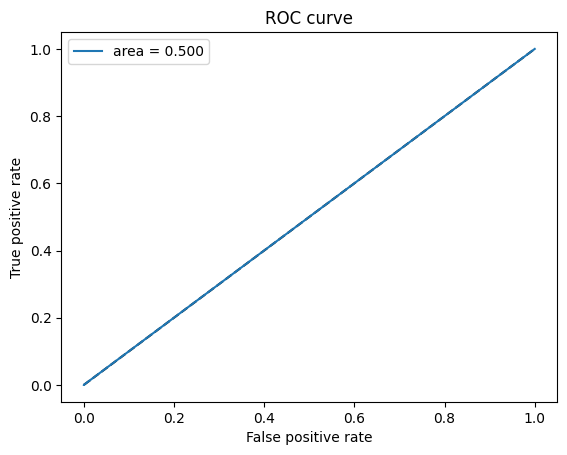

In [18]:
# Plot auc. 
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_pos_r_2, true_pos_r_2, label='area = {:.3f}'.format(auc_val_2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [19]:
# Load the test data. 
test_2 = pd.read_csv("../input/histopathologic-cancer-detection/sample_submission.csv")
print(test_2)

# Test directory. 
test_dir = "../input/histopathologic-cancer-detection/test/"

# Add a path column to the test dataframe.
test_2['path'] = test_dir + test_2['id'] + '.tif'

# Create a data generator for the test data.
test_datagen_2 = ImageDataGenerator(rescale=1./255)

test_generator_2 = test_datagen_2.flow_from_dataframe(
    dataframe=test_2,
    x_col="path",
    y_col=None,  
    target_size=(96, 96),
    batch_size=256,
    class_mode=None,  
    shuffle=False)  

# Use the model to make predictions.
predictions_2 = model_2.predict(test_generator_2)


                                             id  label
0      0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1      95596b92e5066c5c52466c90b69ff089b39f2737      0
2      248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3      2c35657e312966e9294eac6841726ff3a748febf      0
4      145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
...                                         ...    ...
57453  061847314ded6f81e1cd670748bfa2003442c9c7      0
57454  6f3977130212641fd5808210015a609c658dcbff      0
57455  46935f247278539eca74b54d07d666efb528a753      0
57456  a09bcae08a82120183352e0e869181b2911d3dc1      0
57457  d29233dc0b90c2e1a8fcedbc3e1234c3d4dbd55b      0

[57458 rows x 2 columns]
Found 57458 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


224/225 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

2024-04-15 15:26:15.555226: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8839: 5.78342, expected 5.08531
2024-04-15 15:26:15.555284: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8845: 5.38477, expected 4.68667
2024-04-15 15:26:15.555294: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8846: 5.85401, expected 5.1559
2024-04-15 15:26:15.555302: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8847: 5.43135, expected 4.73325
2024-04-15 15:26:15.555310: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8864: 5.76017, expected 5.06206
2024-04-15 15:26:15.555317: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8882: 5.78178, expected 5.08367
2024-04-15 15:26:15.555325: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8896: 5.69229, expected 4.99419
2024-04-15 15:26:15.555333: E exter

225/225 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step


In [20]:
# Convert predictions to class labels.
test_2['label'] = (predictions_2 > 0.5).astype(int)

# Remove path column.
test_2.drop(['path'], axis=1, inplace=True)

# Write submission. 
test_2.to_csv("submission.csv", index = False, header = True)
print(pd.read_csv("submission.csv"))
print(test_2.label.value_counts())

                                             id  label
0      0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1      95596b92e5066c5c52466c90b69ff089b39f2737      1
2      248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3      2c35657e312966e9294eac6841726ff3a748febf      0
4      145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
...                                         ...    ...
57453  061847314ded6f81e1cd670748bfa2003442c9c7      0
57454  6f3977130212641fd5808210015a609c658dcbff      0
57455  46935f247278539eca74b54d07d666efb528a753      0
57456  a09bcae08a82120183352e0e869181b2911d3dc1      0
57457  d29233dc0b90c2e1a8fcedbc3e1234c3d4dbd55b      1

[57458 rows x 2 columns]
label
1    30262
0    27196
Name: count, dtype: int64


Public score = .8306 = 83.06%

# Conclusion

The simple model, that only included a 2 convolutional layer followed by maxpooling, flattening, and then the sigmoid function did okay after submitting. It got a score of 79.08%. It also had an AUC of 0.649. The more complex model which consisted of 3 convolution layer followed by batch normalization, maxpooling, and then a drop out, flattening, a dense layer, a normalization layer, a dropout layer, and the sigmoid function did a little bit better. It got a score of 83.06%. When looking at the AUC, it got a score of 0.500 which seems a bit odd to me. An AUC of .5 technically means that the model is essentially guessing a 0 or 1 (in this case non-cancerous or cancerous) but the accuracy for the submission file was 83.06%. So unfortunately I think there is some typo or carryover error with the variables. In the sake of time, I am not going to re-run this notebook because it takes over 2 hours to run even with using gpus. One thing that I might change is instead of using an early stop, I would let all of the epochs run and plot training and validation plots for accuracy vs epoch. This would let me see visually if the model is being trained properly or if it is being overtrained (though the early stopping should prevent overtraining).

Focusing on the accruacy of the submission files, the more complex model had better accuracy, this could be due to the extra convolution layer, the drop out layers, normalization layers, extra desnse layers, or a combination of them. There are some other ways to improve this model. The complex model only included normalization of the images in the very first step of the model. However, one could manipulate the image (flip, rotate, stretch, etc.) in some way to potentially get more information out of the image. Though more layers were added in the complex model, more hyperparameters could be tuned which could lead to better accuracy (strides, padding, more layers, less layers, different activations, different optimizers, learning rate, etc.). With more time and resources, I would explore some of these options, specifically different preprocessing (flips) and different layers. 

# References

Tensorflow:

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

https://www.tensorflow.org/api_docs/python/tf/keras/layers

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Kaggle:

https://www.kaggle.com/code/mattison/cancer-cnn-detection

https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb